
# Question Answering 模型对比实验（四类QA + 中英场景）

根据搜索得知，目前存在4种问答模型：

| QA 类型 | 模型名称 | 模型说明 |
|--------|----------|----------|
| 抽取式（Extractive） | `distilbert/distilbert-base-cased-distilled-squad` | 从 context 中抽取 span |
| 生成式（Abstractive） | `t5-base` | 可生成改写答案 |
| 开放式（Open-domain） | `deepset/roberta-base-squad2`（模拟开放式） | 使用 context 回答，近似开放域行为 |
| 闭卷式（Closed-book） | `google/flan-t5-base` | 无 context，仅根据问题输出 |

三类语言场景：
- 中文问答
- 英文问答
- 中英混合问答

本实验为了和作业做对比，仅对抽取式进行对比

我在huggingface网站按照Most downloads排序，排第一的是deepset/roberta-base-squad2模型

我在加上同时支持中英文，Most downloads排序，排第一的是distilbert/distilbert-base-cased-distilled-squad模型

通过实验，以上三种模型在中文的表现都不好，通过搜索增加了FlagAlpha/Llama2-Chinese-7b-Chat模型用于测试中文方面的表现

非常遗憾的是，我电脑跑这个Llama2-Chinese-7b-Chat，始终跑步起来，所以本试验暂不跑Llama2-Chinese-7b-Chat模型了

In [1]:

import time
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体（适配 matplotlib）
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False


In [2]:

MODELS = {
    "抽取式01": {
        "pipeline": pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
    },
    "抽取式02": {
        "pipeline": pipeline("question-answering", model="deepset/roberta-base-squad2")
    },
    "抽取式03": {
        "pipeline": pipeline("question-answering", model="distilbert/distilbert-base-cased-distilled-squad")
    }
    
}


D:\javaTools\anaconda\envs\peft\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:

TESTS = {
    "中文": {
        "question": "中国的首都是哪？",
        "context": "中国的首都是北京，拥有悠久的历史。"
    },
    "英文": {
        "question": "What is the capital of China?",
        "context": "The capital of China is Beijing, a city with a long history."
    },
    "中英混合": {
        "question": "Where is the capital of China? 北京是首都吗？",
        "context": "北京 (Beijing) is the capital of China."
    }
}


In [4]:

results = []

for qa_type, qa_info in MODELS.items():
    pipe = qa_info["pipeline"]
    for lang, qa in TESTS.items():
        start = time.time()
        res = pipe(question=qa["question"], context=qa["context"])
        output = res["answer"]
        score = round(res["score"], 4)
        end = time.time()
        results.append({
            "类型": qa_type,
            "语言场景": lang,
            "答案": output,
            "耗时(秒)": round(end - start, 3),
            "得分": score  # None 会自动显示为空
        })

df = pd.DataFrame(results)
df



,类型,语言场景,答案,耗时(秒),得分
0,抽取式01,中文,北京,0.117,0.1195
1,抽取式01,英文,Beijing,0.061,0.9931
2,抽取式01,中英混合,Beijing,0.066,0.5670
3,抽取式02,中文,拥有悠久的历史,0.215,0.0005
4,抽取式02,英文,Beijing,0.123,0.9348
5,抽取式02,中英混合,Beijing,0.171,0.8488
6,抽取式03,中文,北京,0.064,0.1195
7,抽取式03,英文,Beijing,0.064,0.9931
8,抽取式03,中英混合,Beijing,0.071,0.5670


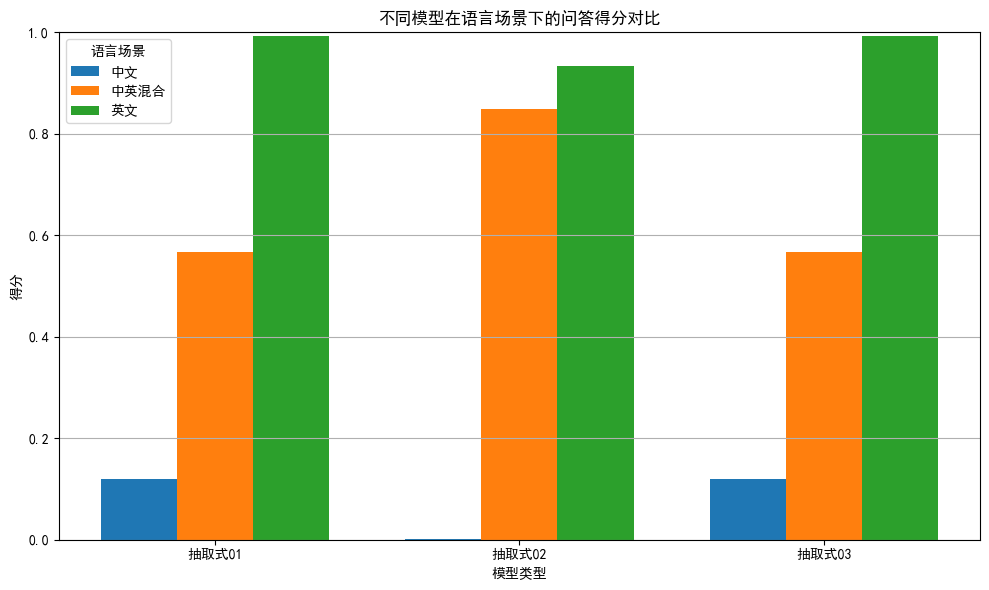

In [8]:

# 绘图
pivot = df.pivot(index="类型", columns="语言场景", values="得分")

plt.figure(figsize=(10, 6))
bar_width = 0.25
x = range(len(pivot.index))
langs = pivot.columns.tolist()

for i, lang in enumerate(langs):
    plt.bar([p + i * bar_width for p in x], pivot[lang], width=bar_width, label=lang)

plt.xticks([p + bar_width for p in x], pivot.index)
plt.title("不同模型在语言场景下的问答得分对比")
plt.xlabel("模型类型")
plt.ylabel("得分")
plt.ylim(0, 1.0)
plt.legend(title="语言场景")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("模型问答得分对比图.png")
plt.show()
